# The Book Club Algorithm

Over the years, I have joined several book clubs. They cover different genres of literature, have different membership demographics, and devote different proportions of each meeting to actually talking about books. But they have one thing in common: each group has to decide, collectively, what to choose for its _next_ book. Each club has evolved its own means for making that decision, be it a vote of the membership, a “rotating dictator,” a permanent moderator who has the last word following discussion, or some other means. Only a total nerd—someone obsessed with finding technical solutions to social problems—would even conceive of farming off this decision-making process to some new-fangled algorithm.

In [1]:
from collections import defaultdict
import math
import matplotlib.pyplot as plt

I will use Python `dict` objects to model a club’s answer to the “what is our next book?” question. First, I will create a `dict` representing the history of previous decisions, in which the keys are the names of club members, and the values represent how many times the club has chosen that member’s favored book.

In [2]:
history = {'alice': 5, 'bob': 3, 'carol': 2, 'dave': 1, 'edith': 0}

Next, there is a two-level `dict` representing the members’ preferences for the next book. In this example, the club uses [approval voting](https://en.wikipedia.org/wiki/Approval_voting), in which each member can show support for multiple candidates. Other systems are of course possible, such as only permitting one vote per member, or allowing different numbers to express different strengths of preference.

In [3]:
raw_votes = {
    'the great gatsby': {'alice', 'bob', 'carol'},
    'native son': {'alice', 'bob'},
    'the five love languages': {'carol', 'dave'},
    'atlas shrugged': {'edith'}
}
votes = defaultdict(lambda: defaultdict(int))
for title, names in raw_votes.items():
    for name in names:
        votes[title][name] += 1
votes

defaultdict(<function __main__.<lambda>()>,
            {'the great gatsby': defaultdict(int,
                         {'alice': 1, 'carol': 1, 'bob': 1}),
             'native son': defaultdict(int, {'alice': 1, 'bob': 1}),
             'the five love languages': defaultdict(int,
                         {'dave': 1, 'carol': 1}),
             'atlas shrugged': defaultdict(int, {'edith': 1})})

We can treat each (top-level) value of `votes`, as well as `history`, as a vector in _N_-dimensional space, where _N_ is the number of club members. The vector, of course, has a magnitude, defined in the usual way.

In [4]:
def norm(vdict):
    return math.sqrt(sum([v**2 for v in vdict.values()]))

Each vote-vector makes a certain angle with the history-vector. If the angle is zero, then the preferences for that book are _exactly like_ the club’s historical preferences. If the two vector are at right angles, then the preferences for the book are _completely different from_ the history.

In [5]:
def angle_with_history(vdict):
    dot_product = 0
    for name, vote in vdict.items():
        dot_product += vote * history.get(name, 0)
    similarity = dot_product / (norm(vdict) * norm(history))
    return math.acos(similarity)

Now we can make a graph representing the club’s votes. Points farther from the origin represent books that have more votes. Points farther from the horizontal axis represents books favored by more members who, historically, did not get their way.

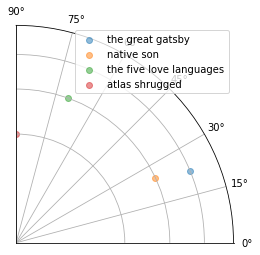

In [6]:
fig = plt.figure()
ax = fig.add_subplot(projection='polar')
ax.set_thetalim(0, math.pi/2)
ax.set_rlim(0, 2)
ax.set_rticks([0, 1, math.sqrt(2), math.sqrt(3)], [])
for name in votes.keys():
    vote = votes[name]
    ax.scatter(
        [angle_with_history(vote)],
        [norm(vote)],
        label=name,
        alpha=0.5
    )
ax.legend()
plt.show()

We can adjust the magnitude of each vote-vector according to its angle, giving greater influence to the people who were losers in previous rounds of voting.

In [7]:
adjusted_votes = dict()
for title, vote in votes.items():
    magnitude = norm(vote)
    scale_factor = math.sin(angle_with_history(vote))
    adjusted_votes[title] = magnitude * scale_factor
sorted(adjusted_votes.items(), key=lambda x: -x[1])

[('the five love languages', 1.3301243435223524),
 ('atlas shrugged', 1.0),
 ('the great gatsby', 0.6602252917735243),
 ('native son', 0.5991446895152784)]

I confess that even when the book clubs I belong to have spent considerable time mulling over the question of “what book to read next,” nobody seems terribly interested in the _meta_-problem of “what procedure should we use to decide ‘what book to read next,’” so this algorithm probably will not interest them. In my own defense, I can only say that giving pedantic answers to questions nobody asked is my love language.